In [14]:
import numpy as np
from scipy.stats import beta

class Environment:
    def __init__(self, a, b, T, samples=None):
        self.a = a
        self.b = b
        self.T = T
        self.current_round = 0

        # Generate and store T samples from Beta(a, b) if none provided
        if samples is not None:
            if len(samples) != T:
                raise ValueError("Length of provided samples must be equal to T.")
            self.samples = np.array(samples)
        else:
            self.samples = beta.rvs(a, b, size=T)

    def reset(self):
        self.current_round = 0

    def play_round(self):
        if self.current_round >= self.T:
            raise StopIteration("All rounds have been played.")
        x = self.samples[self.current_round]
        self.current_round += 1
        return x

    def get_all_samples(self):
        return self.samples


In [15]:
env = Environment(a=2, b=5, T=10)
for _ in range(10):
    print(env.play_round())

# Reset and play again (same values)
env.reset()
print("After reset:")
for _ in range(10):
    print(env.play_round())


0.2924812065337367
0.2173086659589546
0.08483737876790937
0.16367199970955823
0.17952663792351636
0.3783952372109
0.39317610657869795
0.3552240320557683
0.1434941741724978
0.11585344660928087
After reset:
0.2924812065337367
0.2173086659589546
0.08483737876790937
0.16367199970955823
0.17952663792351636
0.3783952372109
0.39317610657869795
0.3552240320557683
0.1434941741724978
0.11585344660928087


In [16]:
class OracleAgent:
    def __init__(self, arm_values, a, b):
        self.arm_values = np.array(arm_values)
        self.a = a
        self.b = b
        self.expected_valuation = a / (a + b)
        self.expected_rewards = [
            (1 - beta.cdf(v, a, b)) * v for v in self.arm_values
        ]
        self.best_arm_index = int(np.argmax(self.expected_rewards))

    def choose_arm(self):
        return self.best_arm_index

    def update(self, chosen_arm, reward):
        pass  # Oracle doesn't need to update anything


In [17]:
import numpy as np

class UCBAgent:
    def __init__(self, arm_values, total_rounds):
        """
        Classic UCB1 agent.
        
        Parameters:
        - arm_values: list of arm values (prices)
        - total_rounds: number of rounds (T), used in log term
        """
        self.arm_values = np.array(arm_values)
        self.K = len(arm_values)
        self.T = total_rounds
        
        self.counts = np.zeros(self.K, dtype=int)       # Number of times each arm was pulled
        self.successes = np.zeros(self.K, dtype=float)  # Sum of rewards from each arm
        self.t = 0                                       # Time step

    def choose_arm(self):
        # Pull each arm once first (initialization)
        if self.t < self.K:
            return self.t
        
        # Compute UCB for each arm
        ucb_values = np.zeros(self.K)
        for i in range(self.K):
            mean_reward = self.successes[i] / self.counts[i]
            exploration = np.sqrt((2 * np.log(self.t + 1)) / self.counts[i])
            ucb_values[i] = mean_reward + exploration

        return int(np.argmax(ucb_values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        self.successes[chosen_arm] += reward
        self.t += 1

In [18]:
def simulate(env, agent, arm_values):
    total_reward = 0
    history = []

    env.reset()
    for t in range(env.T):
        arm_index = agent.choose_arm()
        arm_value = arm_values[arm_index]

        valuation = env.play_round()
        reward = arm_value if valuation >= arm_value else 0

        agent.update(arm_index, reward)  # ← very important!

        total_reward += reward
        history.append((t, arm_index, valuation, reward))

    return total_reward, history

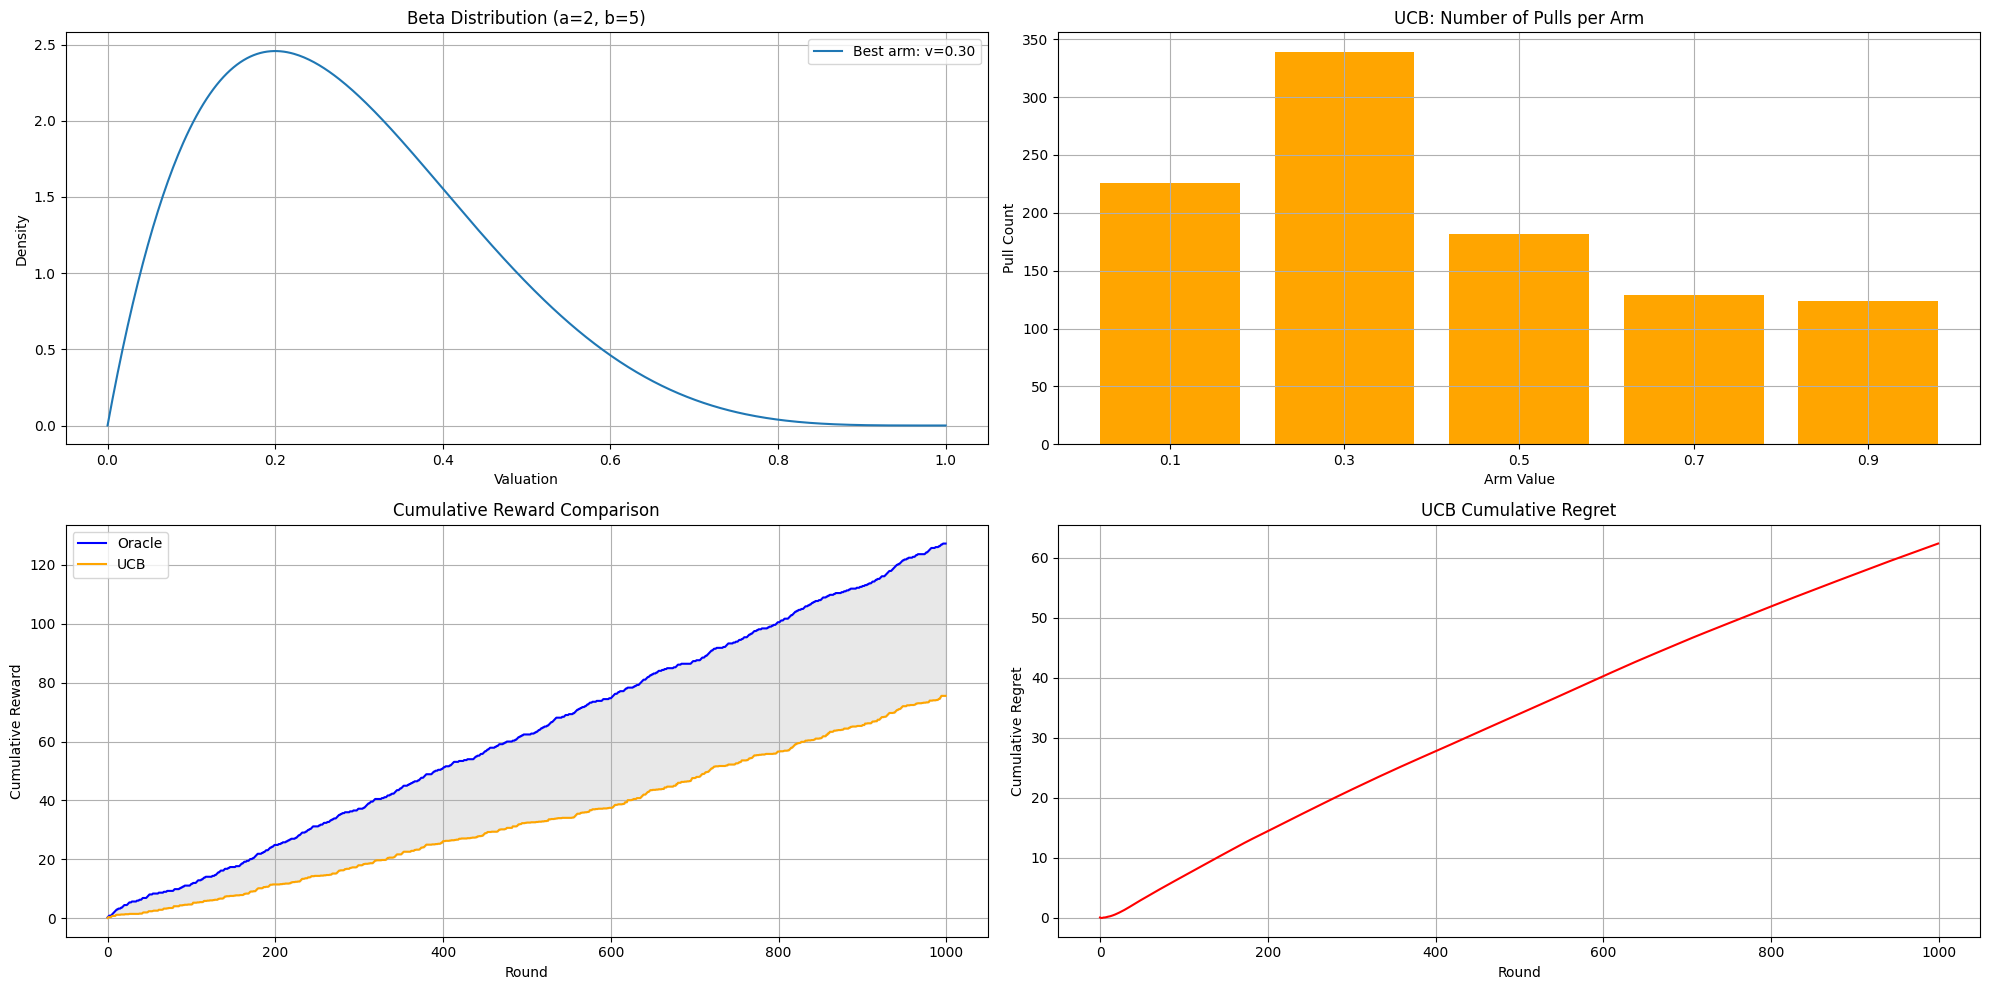

Total Reward (Oracle): 127.20
Total Reward (UCB):    75.50
Best Arm (Oracle):     index 2, value 0.30


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# --- Configuration ---
arm_values = [0.1, 0.3, 0.5, 0.7, 0.9]
a, b = 2, 5
T = 1000

# --- Fixed Environment ---
# Generate one shared set of valuations
shared_samples = beta.rvs(a, b, size=T)

# Create environments for both agents using the same valuations
env_oracle = Environment(a, b, T, samples=shared_samples)
env_ucb = Environment(a, b, T, samples=shared_samples)

# --- Create Agents ---
oracle = OracleAgent(arm_values, a, b)
ucb = UCBAgent(arm_values, T)

# --- Simulate Both Agents ---
total_reward_oracle, history_oracle = simulate(env_oracle, oracle, arm_values)
total_reward_ucb, history_ucb = simulate(env_ucb, ucb, arm_values)

# --- Extract Rewards and Stats ---
rewards_oracle = [h[3] for h in history_oracle]
rewards_ucb = [h[3] for h in history_ucb]
cumulative_rewards_oracle = np.cumsum(rewards_oracle)
cumulative_rewards_ucb = np.cumsum(rewards_ucb)

# --- Compute Regret ---
# Expected reward of oracle (same at each round)
expected_reward_oracle = oracle.expected_rewards[oracle.best_arm_index]
regret = np.cumsum([expected_reward_oracle - (r / (t + 1)) for t, r in enumerate(np.cumsum(rewards_ucb))])

# --- Plot Everything ---
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# 1. Plot Beta Distribution
x = np.linspace(0, 1, 500)
pdf = beta.pdf(x, a, b)
best_arm_index = oracle.best_arm_index
best_arm_value = arm_values[best_arm_index]

axs[0, 0].plot(x, pdf, label=f"Best arm: v={best_arm_value:.2f}")
axs[0, 0].set_title(f"Beta Distribution (a={a}, b={b})")
axs[0, 0].set_xlabel("Valuation")
axs[0, 0].set_ylabel("Density")
axs[0, 0].legend()
axs[0, 0].grid(True)

# 2. Histogram of Arm Pulls by UCB
axs[0, 1].bar(range(len(arm_values)), ucb.counts, tick_label=[f"{v:.1f}" for v in arm_values], color='orange')
axs[0, 1].set_title("UCB: Number of Pulls per Arm")
axs[0, 1].set_xlabel("Arm Value")
axs[0, 1].set_ylabel("Pull Count")
axs[0, 1].grid(True)

# 3. Cumulative Rewards (Both Agents)
axs[1, 0].plot(cumulative_rewards_oracle, label="Oracle", color='blue')
axs[1, 0].plot(cumulative_rewards_ucb, label="UCB", color='orange')
axs[1, 0].fill_between(range(T), cumulative_rewards_ucb, cumulative_rewards_oracle, color='lightgray', alpha=0.5)
axs[1, 0].set_title("Cumulative Reward Comparison")
axs[1, 0].set_xlabel("Round")
axs[1, 0].set_ylabel("Cumulative Reward")
axs[1, 0].legend()
axs[1, 0].grid(True)

# 4. Cumulative Regret of UCB
axs[1, 1].plot(regret, color='red')
axs[1, 1].set_title("UCB Cumulative Regret")
axs[1, 1].set_xlabel("Round")
axs[1, 1].set_ylabel("Cumulative Regret")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# --- Summary ---
print(f"Total Reward (Oracle): {total_reward_oracle:.2f}")
print(f"Total Reward (UCB):    {total_reward_ucb:.2f}")
print(f"Best Arm (Oracle):     index {best_arm_index +1}, value {best_arm_value:.2f}")

In [20]:
from scipy.optimize import linprog
import numpy as np

class BudgetedOracleAgent:
    def __init__(self, arm_values, a, b, T, B):
        self.arm_values = np.array(arm_values)
        self.a = a
        self.b = b
        self.T = T
        self.B = B

        # Oracle knowledge
        self.success_probs = 1 - beta.cdf(self.arm_values, a, b)
        self.expected_rewards = self.success_probs * self.arm_values

        self.round = 0
        self.budget_remaining = B

    def choose_arm(self):
        rounds_remaining = self.T - self.round
        if rounds_remaining <= 0 or self.budget_remaining <= 0:
            return None  # No more plays allowed

        # Allowed expected budget use per round
        max_expected_usage = self.budget_remaining / rounds_remaining

        # LP: maximize expected reward over x
        # Objective: maximize sum x_i * reward_i → linprog minimizes, so negate
        c = -self.expected_rewards

        # Constraints:
        A = [self.success_probs]                   # budget usage in expectation
        b = [max_expected_usage]

        A_eq = [np.ones(len(self.arm_values))]     # sum x_i = 1
        b_eq = [1]

        bounds = [(0, 1) for _ in self.arm_values]

        res = linprog(c, A_ub=A, b_ub=b, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

        if not res.success:
            # Fallback: safest arm
            return int(np.argmin(self.success_probs))

        # Sample an arm from the mixed strategy
        x = res.x
        arm_index = np.random.choice(len(self.arm_values), p=x)
        return arm_index

    def update(self, chosen_arm, reward):
        self.round += 1
        if reward > 0:
            self.budget_remaining -= 1

In [21]:
def simulate(env, agent, arm_values):
    total_reward = 0
    history = []

    env.reset()
    for t in range(env.T):
        arm_index = agent.choose_arm()
        if arm_index is None:
            break

        arm_value = arm_values[arm_index]
        valuation = env.play_round()

        reward = arm_value if valuation >= arm_value else 0
        agent.update(arm_index, reward)

        total_reward += reward
        history.append((t, arm_index, valuation, reward))

    return total_reward, history

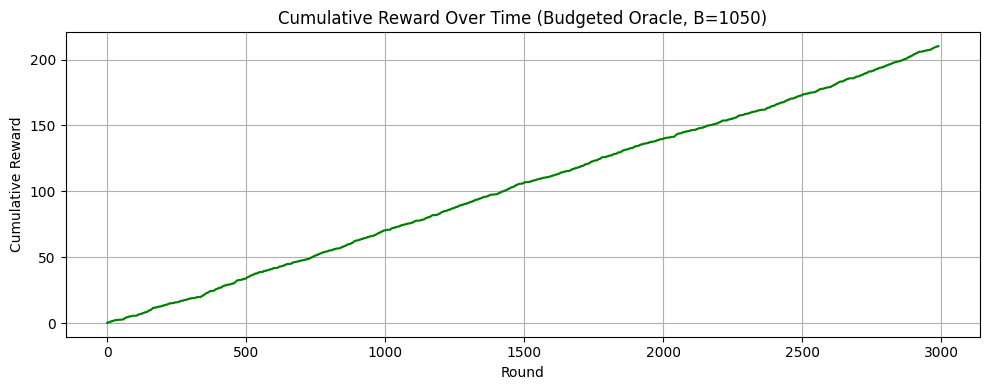

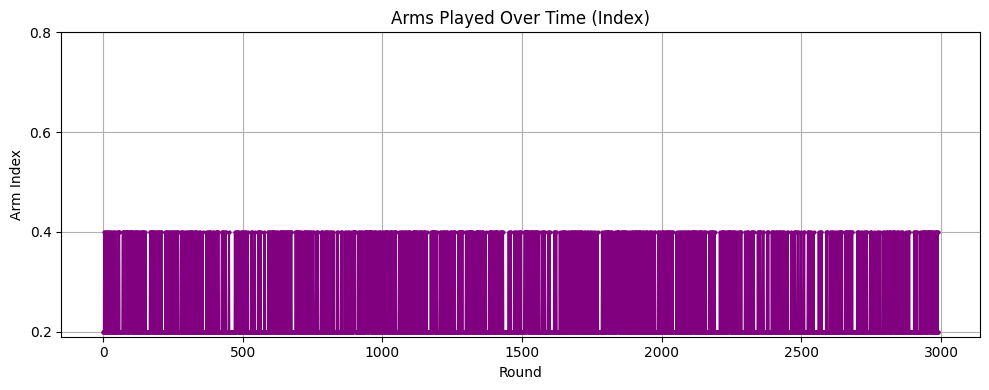

Total Reward: 210.20
Total Rounds Played: 2991
Total Budget Used: 1050 / 1050


In [22]:
import matplotlib.pyplot as plt

# --- Configuration ---
arm_values = [0.2, 0.4, 0.6, 0.8]
a, b = 10, 40
T = 3000
B = 1050  # total sells allowed

# --- Shared Environment Samples ---
samples = beta.rvs(a, b, size=T)
env = Environment(a, b, T, samples=samples)

# --- Create Budgeted Oracle Agent ---
agent = BudgetedOracleAgent(arm_values, a, b, T, B)

# --- Run Simulation ---
total_reward, history = simulate(env, agent, arm_values)

# --- Extract Data for Plotting ---
rounds = [h[0] for h in history]
played_arms = [h[1] for h in history]
rewards = [h[3] for h in history]
cumulative_rewards = np.cumsum(rewards)

# --- Plot 1: Cumulative Reward Over Time ---
plt.figure(figsize=(10, 4))
plt.plot(rounds, cumulative_rewards, label="Cumulative Reward", color='green')
plt.title(f"Cumulative Reward Over Time (Budgeted Oracle, B={B})")
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Arms Played Over Time ---
plt.figure(figsize=(10, 4))
plt.plot(rounds, played_arms, linestyle='-', marker='o', markersize=2, color='purple')
plt.title("Arms Played Over Time (Index)")
plt.xlabel("Round")
plt.ylabel("Arm Index")
plt.yticks(range(len(arm_values)), labels=[f"{v:.1f}" for v in arm_values])
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print Summary ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Total Rounds Played: {len(rounds)}")
print(f"Total Budget Used: {B - agent.budget_remaining} / {B}")

In [23]:
import numpy as np
from scipy.optimize import linprog

class BudgetedUCBAgent:
    def __init__(self, arm_values, T, B):
        self.arm_values = np.array(arm_values)
        self.K = len(arm_values)
        self.T = T
        self.B = B
        self.remaining_budget = B

        self.counts = np.zeros(self.K)
        self.successes = np.zeros(self.K)
        self.total_rewards = np.zeros(self.K)

        self.t = 0

    def choose_arm(self):
        self.t += 1

        # Play each arm once initially
        for i in range(self.K):
            if self.counts[i] == 0:
                return i

        # Empirical estimates
        mean_reward = self.total_rewards / self.counts
        mean_success_prob = self.successes / self.counts  # expected cost per play = prob(sale)

        confidence = np.sqrt(2 * np.log(self.T) / self.counts)

        ucb_reward = mean_reward + confidence
        lcb_cost = np.maximum(mean_success_prob - confidence, 1e-6)

        # LP: max sum γ_i * ucb_reward_i  s.t. sum γ_i * lcb_cost_i ≤ ρ, sum γ_i = 1
        rho = self.remaining_budget / (self.T - self.t + 1)

        c = -ucb_reward  # maximize ⇒ minimize negative
        A_ub = [lcb_cost]
        b_ub = [rho]
        A_eq = [np.ones(self.K)]
        b_eq = [1]
        bounds = [(0, 1) for _ in range(self.K)]

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

        if not res.success:
            # Fallback: greedy choice
            ratios = ucb_reward / lcb_cost
            return np.argmax(ratios)

        gamma = res.x
        return np.random.choice(self.K, p=gamma)

    def update(self, arm_index, reward):
        self.counts[arm_index] += 1
        self.total_rewards[arm_index] += reward
        if reward > 0:
            self.successes[arm_index] += 1
            self.remaining_budget -= 1  # unit cost per sale


In [24]:
def simulate_budgeted(env, agent, arm_values):
    history = []
    env.reset()
    total_reward = 0

    try:
        for _ in range(env.T):
            arm = agent.choose_arm()
            valuation = env.play_round()
            reward = arm_values[arm] if valuation >= arm_values[arm] else 0

            agent.update(arm, reward)
            total_reward += reward

            history.append((arm, valuation, reward, agent.remaining_budget))

            if agent.remaining_budget < 1:
                break
    except StopIteration:
        pass

    return total_reward, history

def plot_budgeted_ucb_results(agent_name, history, arm_values):
    import matplotlib.pyplot as plt

    cumulative_rewards = []
    arms_played = []
    total = 0

    for _, (arm_index, _, reward, _) in enumerate(history):
        total += reward
        cumulative_rewards.append(total)
        arms_played.append(arm_index)

    rounds = list(range(1, len(history) + 1))

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot cumulative reward over time
    axs[0].plot(rounds, cumulative_rewards, color='green', label="Cumulative Reward")
    axs[0].set_title(f"{agent_name}: Cumulative Reward Over Time")
    axs[0].set_xlabel("Round")
    axs[0].set_ylabel("Cumulative Reward")
    axs[0].grid(True)

    # Plot arms played over time
    axs[1].plot(rounds, arms_played, linestyle='-', marker='o', markersize=3, color='blue')
    axs[1].set_title(f"{agent_name}: Arms Played Over Time")
    axs[1].set_xlabel("Round")
    axs[1].set_ylabel("Arm (Index)")
    axs[1].set_yticks(range(len(arm_values)))
    axs[1].set_yticklabels([f"{v:.2f}" for v in arm_values])
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()



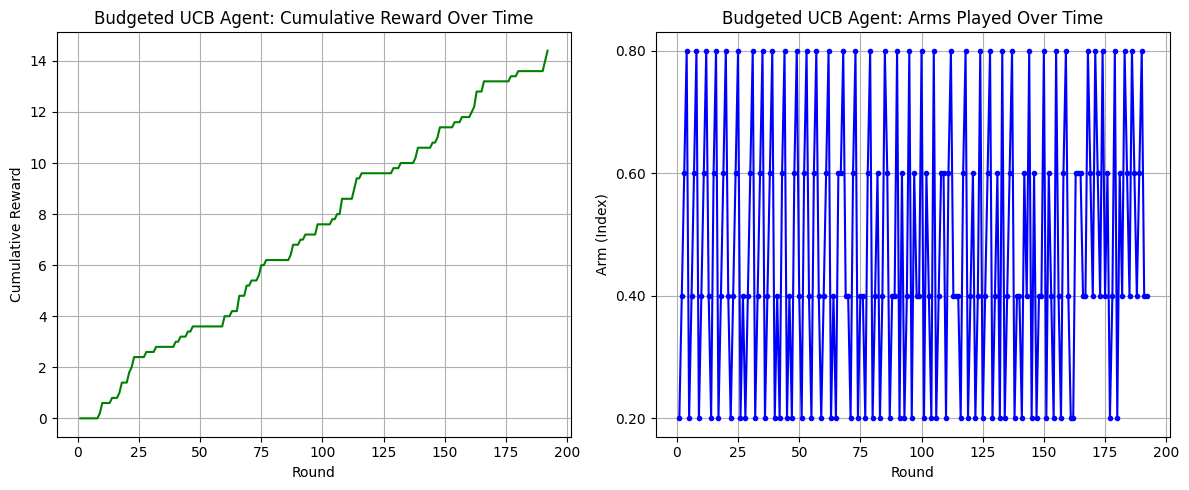

Total reward: 14.40
Remaining budget: 0.00


In [25]:
arm_values = [0.2, 0.4, 0.6, 0.8]
a, b = 2, 5
T = 500
B = 50  # budget

env = Environment(a, b, T)
agent = BudgetedUCBAgent(arm_values, T, B)

total_reward, history = simulate_budgeted(env, agent, arm_values)
plot_budgeted_ucb_results("Budgeted UCB Agent", history, arm_values)

print(f"Total reward: {total_reward:.2f}")
print(f"Remaining budget: {agent.remaining_budget:.2f}")


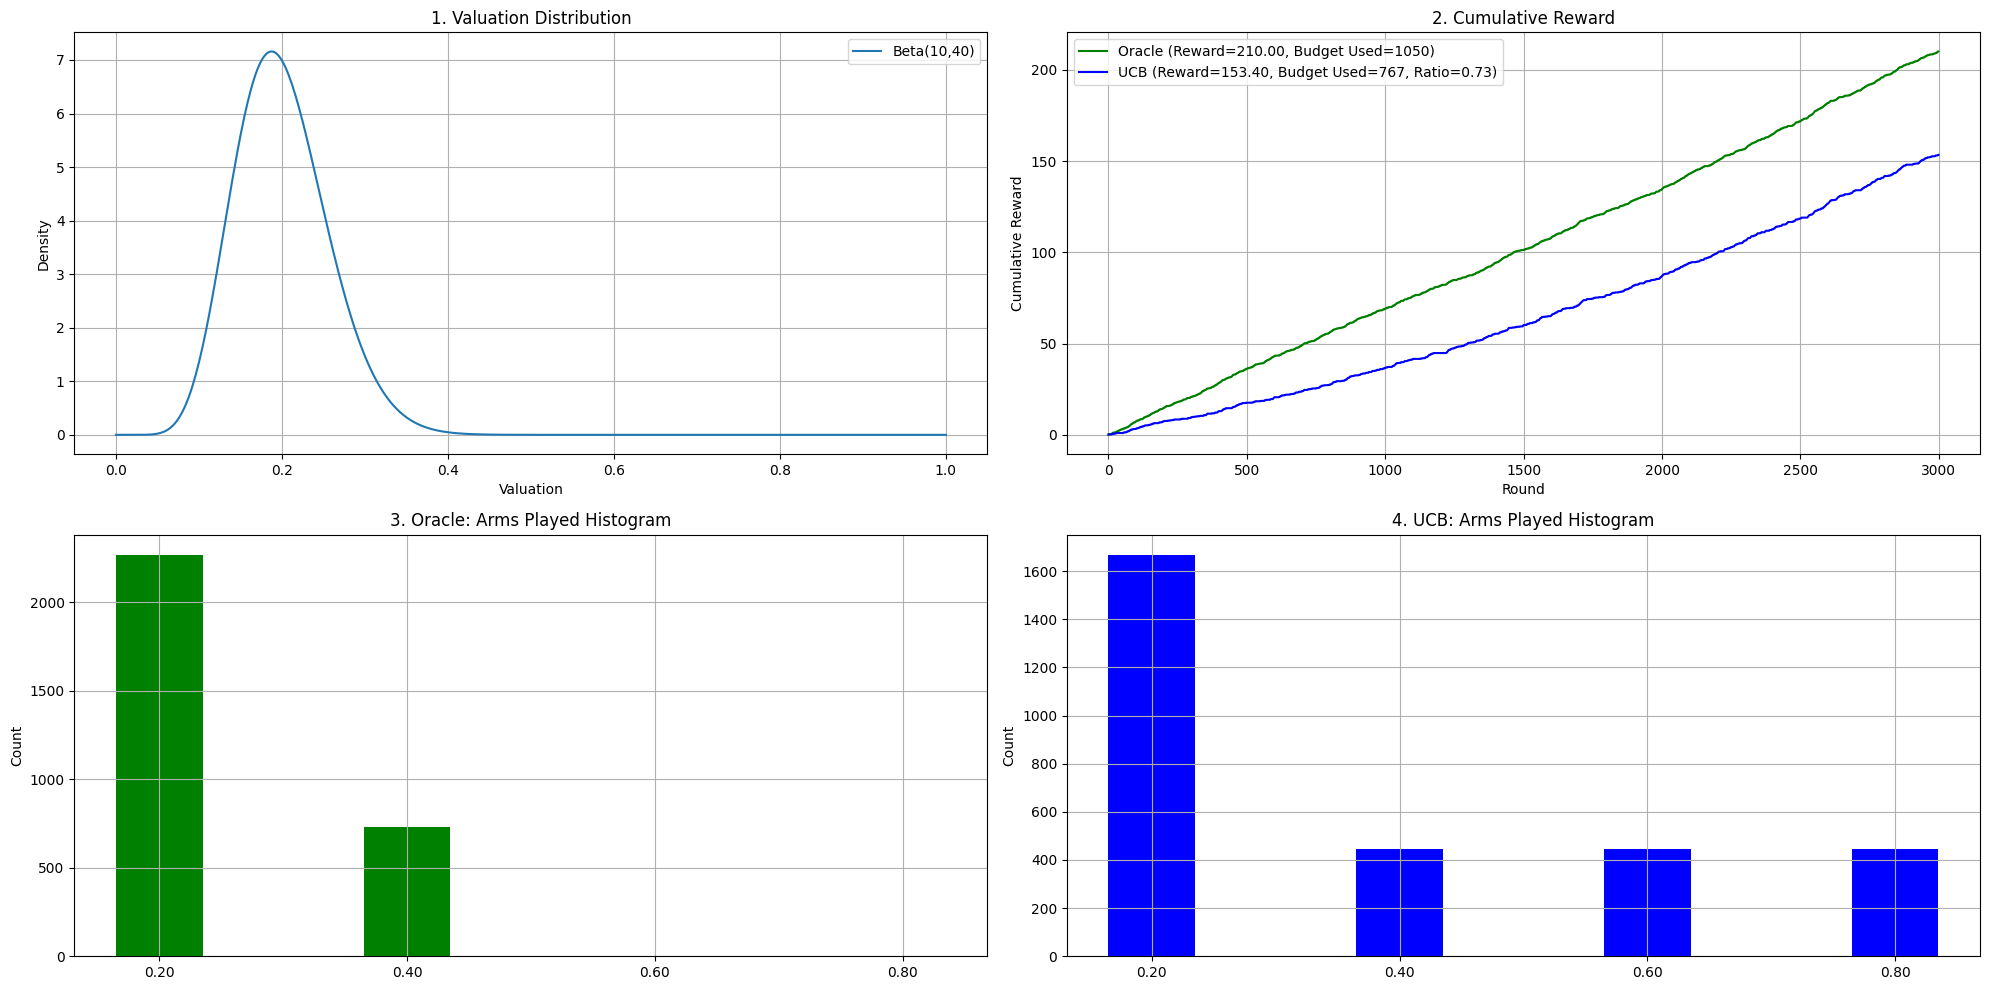

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.optimize import linprog
from collections import Counter

# ----- Environment -----
class Environment:
    def __init__(self, a, b, T, samples=None):
        self.a = a
        self.b = b
        self.T = T
        self.current_round = 0
        self.samples = np.array(samples if samples is not None else beta.rvs(a, b, size=T))

    def reset(self):
        self.current_round = 0

    def play_round(self):
        if self.current_round >= self.T:
            raise StopIteration("All rounds have been played.")
        x = self.samples[self.current_round]
        self.current_round += 1
        return x

# ----- Budgeted Oracle Agent -----
class BudgetedOracleAgent:
    def __init__(self, arm_values, a, b, T, B):
        self.arm_values = np.array(arm_values)
        self.a = a
        self.b = b
        self.T = T
        self.B = B
        self.success_probs = 1 - beta.cdf(self.arm_values, a, b)
        self.expected_rewards = self.success_probs * self.arm_values
        self.round = 0
        self.budget_remaining = B

    def choose_arm(self):
        rounds_remaining = self.T - self.round
        if rounds_remaining <= 0 or self.budget_remaining < 1:
            return None
        max_expected_usage = self.budget_remaining / rounds_remaining
        c = -self.expected_rewards
        A = [self.success_probs]
        b = [max_expected_usage]
        A_eq = [np.ones(len(self.arm_values))]
        b_eq = [1]
        bounds = [(0, 1)] * len(self.arm_values)

        res = linprog(c, A_ub=A, b_ub=b, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
        if not res.success:
            return int(np.argmin(self.success_probs))
        x = res.x
        return np.random.choice(len(self.arm_values), p=x)

    def update(self, chosen_arm, reward):
        self.round += 1
        if reward > 0:
            self.budget_remaining -= 1  # unit cost per sale

# ----- Budgeted UCB Agent -----
class BudgetedUCBAgent:
    def __init__(self, arm_values, T, B):
        self.arm_values = np.array(arm_values)
        self.K = len(arm_values)
        self.T = T
        self.B = B
        self.remaining_budget = B
        self.counts = np.zeros(self.K)
        self.successes = np.zeros(self.K)
        self.total_rewards = np.zeros(self.K)
        self.t = 0

    def choose_arm(self):
        self.t += 1
        for i in range(self.K):
            if self.counts[i] == 0:
                return i

        mean_reward = self.total_rewards / self.counts
        mean_success_prob = self.successes / self.counts
        confidence = np.sqrt(2 * np.log(self.T) / self.counts)
        ucb_reward = mean_reward + confidence
        lcb_cost = np.maximum(mean_success_prob - confidence, 1e-6)
        rho = self.remaining_budget / (self.T - self.t + 1)

        c = -ucb_reward
        A_ub = [lcb_cost]
        b_ub = [rho]
        A_eq = [np.ones(self.K)]
        b_eq = [1]
        bounds = [(0, 1) for _ in range(self.K)]

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

        if not res.success:
            ratios = ucb_reward / lcb_cost
            return np.argmax(ratios)

        gamma = res.x
        return np.random.choice(self.K, p=gamma)

    def update(self, arm_index, reward):
        self.counts[arm_index] += 1
        self.total_rewards[arm_index] += reward
        if reward > 0:
            self.successes[arm_index] += 1
            self.remaining_budget -= 1  # unit cost per sale

# ----- Simulation -----
def simulate(env, agent, arm_values):
    total_reward = 0
    history = []
    env.reset()

    for t in range(env.T):
        arm = agent.choose_arm()
        if arm is None:
            break
        valuation = env.play_round()
        reward = arm_values[arm] if valuation >= arm_values[arm] else 0
        agent.update(arm, reward)
        total_reward += reward
        history.append((t, arm, valuation, reward))
        if hasattr(agent, "remaining_budget") and agent.remaining_budget < 1:
            break
    return total_reward, history

# ----- Plotting -----
def plot_results(oracle_history, ucb_history, arm_values, a, b):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    # 1. Valuation distribution
    x = np.linspace(0, 1, 500)
    axs[0, 0].plot(x, beta.pdf(x, a, b), label=f"Beta({a},{b})")
    axs[0, 0].set_title("1. Valuation Distribution")
    axs[0, 0].set_xlabel("Valuation")
    axs[0, 0].set_ylabel("Density")
    axs[0, 0].grid(True)
    axs[0, 0].legend()

   # 2. Cumulative reward
    oracle_cum = np.cumsum([r for _, _, _, r in oracle_history])
    ucb_cum = np.cumsum([r for _, _, _, r in ucb_history])

    # Final cumulative rewards
    oracle_total_reward = oracle_cum[-1]
    ucb_total_reward = ucb_cum[-1]

    # Budget used
    oracle_budget_used = B - oracle.budget_remaining
    ucb_budget_used = B - ucb.remaining_budget

    # Reward ratio
    reward_ratio = ucb_total_reward / oracle_total_reward if oracle_total_reward > 0 else 0

    # Formatted legend labels
    oracle_label = f"Oracle (Reward={oracle_total_reward:.2f}, Budget Used={oracle_budget_used})"
    ucb_label = f"UCB (Reward={ucb_total_reward:.2f}, Budget Used={ucb_budget_used}, Ratio={reward_ratio:.2f})"

    axs[0, 1].plot(oracle_cum, label=oracle_label, color="green")
    axs[0, 1].plot(ucb_cum, label=ucb_label, color="blue")
    axs[0, 1].set_title("2. Cumulative Reward")
    axs[0, 1].set_xlabel("Round")
    axs[0, 1].set_ylabel("Cumulative Reward")
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # 3. Oracle arm histogram
    oracle_counts = Counter([a for _, a, _, _ in oracle_history])
    oracle_h = [oracle_counts.get(i, 0) for i in range(len(arm_values))]
    axs[1, 0].bar(range(len(arm_values)), oracle_h, width=0.35, color='green')
    axs[1, 0].set_xticks(range(len(arm_values)))
    axs[1, 0].set_xticklabels([f"{v:.2f}" for v in arm_values])
    axs[1, 0].set_title("3. Oracle: Arms Played Histogram")
    axs[1, 0].set_ylabel("Count")
    axs[1, 0].grid(True)

    # 4. UCB arm histogram
    ucb_counts = Counter([a for _, a, _, _ in ucb_history])
    ucb_h = [ucb_counts.get(i, 0) for i in range(len(arm_values))]
    axs[1, 1].bar(range(len(arm_values)), ucb_h, width=0.35, color='blue')
    axs[1, 1].set_xticks(range(len(arm_values)))
    axs[1, 1].set_xticklabels([f"{v:.2f}" for v in arm_values])
    axs[1, 1].set_title("4. UCB: Arms Played Histogram")
    axs[1, 1].set_ylabel("Count")
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# ----- Run Simulation -----
T = 3000
B = 1050
a, b = 10, 40
arm_values = [0.2, 0.4, 0.6, 0.8]
samples = beta.rvs(a, b, size=T)

env1 = Environment(a, b, T, samples=samples.copy())
env2 = Environment(a, b, T, samples=samples.copy())

oracle = BudgetedOracleAgent(arm_values, a, b, T, B)
ucb = BudgetedUCBAgent(arm_values, T, B)

_, oracle_history = simulate(env1, oracle, arm_values)
_, ucb_history = simulate(env2, ucb, arm_values)

plot_results(oracle_history, ucb_history, arm_values, a, b)
